In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from casedi_test.survival import ase_compare_survival
from casedi_test.expression import ase_compare_expression
from casedi_test.enrichment import ase_compare_groups

In [26]:
!python3 -m pip install --upgrade --force-reinstall --index-url https://test.pypi.org/simple/ --no-deps casedi-test

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: casedi-test
    Found existing installation: casedi-test 0.0.6
    Uninstalling casedi-test-0.0.6:
      Successfully uninstalled casedi-test-0.0.6


# Examples using CASEDI on toy data

## Expression difference between samples showing ASE and BAE

Generating an example table with ASE data for gene A for 20 tumor samples, where half of samples show ASE and half show BAE

In [3]:
ase_table = pd.DataFrame({'gene': np.repeat('A',20),
                         'ase': np.concatenate([np.repeat(0,10),np.repeat(1,10)]),
                         'sampleID': np.arange(0,20,1) 
                         })
ase_table

,gene,ase,sampleID
0,A,0,0
1,A,0,1
2,A,0,2
3,A,0,3
4,A,0,4
5,A,0,5
6,A,0,6
7,A,0,7
8,A,0,8
9,A,0,9


Generate gene expression table of samples x genes with normalized expression values

In [6]:
expr = np.concatenate([np.random.randint(0,10,10),np.random.randint(5,10,10)])
expression_table = pd.DataFrame({'A': expr})
expression_table

,A
0,0
1,6
2,6
3,7
4,3
5,2
6,4
7,3
8,5
9,2


Test if samples showing ASE for gene A have different overall expression than samples showing BAE

In [7]:
ase_compare_expression(gene="A", ase_table=ase_table, expression_table=expression_table, alternative='two-sided')

MannwhitneyuResult(statistic=89.0, pvalue=0.0031957347007828857)

## Survival difference between samples showing ASE and BAE

Generate a table with survival times and statuses for each sample. You can use overall survival, progression-free survival, etc.

In [67]:
times = np.concatenate([np.arange(0, 20, 2),np.arange(0, 10, 1)])
survival_table = pd.DataFrame({'survival_time': times, 
                               'survival_status': np.concatenate([[0],np.repeat(1,9),[0],np.repeat(1,9)]), # 0 for no event, 1 for event
                              })
survival_table

,survival_time,survival_status
0,0,0
1,2,1
2,4,1
3,6,1
4,8,1
5,10,1
6,12,1
7,14,1
8,16,1
9,18,1


Perform log-rank test to test for difference in survival between samples showing ASE and BAE for gene A

In [69]:
ase_compare_survival(gene='A',
                     ase_table=ase_table,
                     survival_table=survival_table
                     )

(6.063519058408218, 0.013800242446541905)

Plot Kaplan-Meier

(0.0, 20.0)

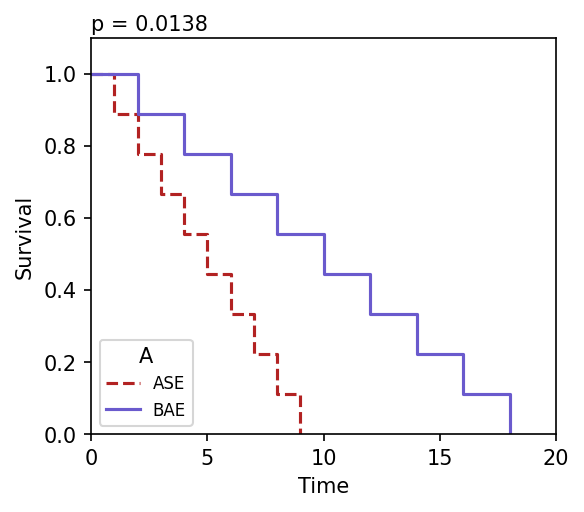

In [70]:
ase_compare_survival(gene='A',
                     ase_table=ase_table,
                     survival_table=survival_table,
                     plot=True
                     )
plt.xlim(0,20)

Further stratify by ASE and high expression

In [71]:
ase_compare_survival(gene='A',
                     ase_table=ase_table,
                     survival_table=survival_table,
                     stratify_expression='ase high',
                     expression_table=expression_table,
                     )

(6.231008985680835, 0.012553218858161578)

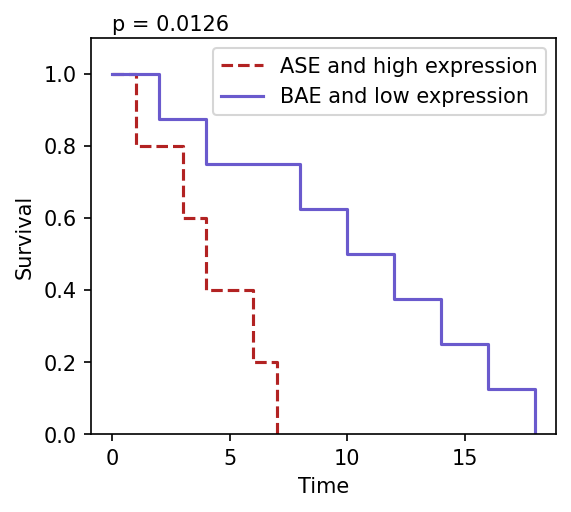

In [72]:
ase_compare_survival(gene='A',
                     ase_table=ase_table,
                     survival_table=survival_table,
                     stratify_expression='ase high',
                     expression_table=expression_table,
                     plot=True
                     )
plt.legend(bbox_to_anchor=(1,1))

## Enrichment analysis between two subgroups

Example: Tumors 0-9 have a gene fusion in gene A and tumors 10-19 do not. Group 1 will be fusion positive tumors, group 2 will be fusion negative tumors

In [15]:
ase_compare_groups(ase_table=ase_table,
                   group1_ids=np.arange(0,10,1),
                   group2_ids=np.arange(10,20,1),
                   testable_fraction=0.1
                   )

mat1 genes showing ASE:  0
mat1 total genes:  1
mat2 genes showing ASE:  1
mat2 total genes:  1
testing 1 genes


,group1_ASE,group1_total,group2_ASE,group2_total,group1_BAE,group2_BAE,odds_ratio,p_val,FDR
A,0.0,10,10,10,10.0,0,0.0,0.000011,0.000011
